<a href="https://colab.research.google.com/github/amyhynes/COMP550-code/blob/master/ootb_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/tensorflow/tpu/blob/master/tools/colab/bert_finetuning_with_cloud_tpus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2018 The TensorFlow Hub Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [0]:
# Copyright 2018 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

# BERT End to End (Fine-tuning + Predicting) in 5 minutes with Cloud TPU

## Overview

**BERT**, or **B**idirectional **E**mbedding **R**epresentations from **T**ransformers, is a new method of pre-training language representations which obtains state-of-the-art results on a wide array of Natural Language Processing (NLP) tasks. The academic paper can be found here: https://arxiv.org/abs/1810.04805.

This Colab demonstates using a free Colab Cloud TPU to fine-tune sentence and sentence-pair classification tasks built on top of pretrained BERT models and 
run predictions on tuned model. The colab demonsrates loading pretrained BERT models from both [TF Hub](https://www.tensorflow.org/hub) and checkpoints.

**Note:**  You will need a GCP (Google Compute Engine) account and a GCS (Google Cloud 
Storage) bucket for this Colab to run.

Please follow the [Google Cloud TPU quickstart](https://cloud.google.com/tpu/docs/quickstart) for how to create GCP account and GCS bucket. You have [$300 free credit](https://cloud.google.com/free/) to get started with any GCP product. You can learn more about Cloud TPU at https://cloud.google.com/tpu/docs.

This notebook is hosted on GitHub. To view it in its original repository, after opening the notebook, select **File > View on GitHub**.

## Learning objectives

In this notebook, you will learn how to train and evaluate a BERT model using TPU.

## Instructions

<h3><a href="https://cloud.google.com/tpu/"><img valign="middle" src="https://raw.githubusercontent.com/GoogleCloudPlatform/tensorflow-without-a-phd/master/tensorflow-rl-pong/images/tpu-hexagon.png" width="50"></a>  &nbsp;&nbsp;Train on TPU</h3>

   1. Create a Cloud Storage bucket for your TensorBoard logs at http://console.cloud.google.com/storage and fill in the BUCKET parameter in the "Parameters" section below.
 
   1. On the main menu, click Runtime and select **Change runtime type**. Set "TPU" as the hardware accelerator.
   1. Click Runtime again and select **Runtime > Run All** (Watch out: the "Colab-only auth for this notebook and the TPU" cell requires user input). You can also run the cells manually with Shift-ENTER.

### Set up your TPU environment

In this section, you perform the following tasks:

*   Set up a Colab TPU running environment
*   Verify that you are connected to a TPU device
*   Upload your credentials to TPU to access your GCS bucket.

In [1]:
import datetime
import json
import os
import pprint
import random
import string
import sys
import tensorflow as tf

assert 'COLAB_TPU_ADDR' in os.environ, 'ERROR: Not connected to a TPU runtime; please see the first cell in this notebook for instructions!'
TPU_ADDRESS = 'grpc://' + os.environ['COLAB_TPU_ADDR']
print('TPU address is', TPU_ADDRESS)

from google.colab import auth
auth.authenticate_user()
with tf.Session(TPU_ADDRESS) as session:
  print('TPU devices:')
  pprint.pprint(session.list_devices())

  # Upload credentials to TPU.
  with open('/content/adc.json', 'r') as f:
    auth_info = json.load(f)
  tf.contrib.cloud.configure_gcs(session, credentials=auth_info)
  # Now credentials are set for all future sessions on this TPU.

TPU address is grpc://10.85.199.218:8470
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

TPU devices:
[_DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:CPU:0, CPU, -1, 2480300072232477589),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 16464546457408430993),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 5104380869087332059),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 4545963880805200791),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 3825109889083436156),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/

In [0]:
import pandas as pd
import numpy as np

### Prepare and import BERT modules
​
With your environment configured, you can now prepare and import the BERT modules. The following step clones the source code from GitHub and import the modules from the source. Alternatively, you can install BERT using pip (!pip install bert-tensorflow).

In [4]:
import sys

!test -d bert_repo || git clone https://github.com/amyhynes/bert.git bert_repo

if not 'bert_repo' in sys.path:
  sys.path += ['bert_repo']

# import python modules defined by BERT
import modeling
import optimization
import run_classifier
import run_classifier_with_tfhub
import tokenization

# import tfhub 
import tensorflow_hub as hub

Cloning into 'bert_repo'...
remote: Enumerating objects: 11, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 389 (delta 4), reused 7 (delta 2), pack-reused 378
Receiving objects: 100% (389/389), 300.61 KiB | 3.85 MiB/s, done.
Resolving deltas: 100% (217/217), done.


In [0]:
import csv

### Prepare for training

This next section of code performs the following tasks:

*  Specify task and download training data.
*  Specify BERT pretrained model
*  Specify GS bucket, create output directory for model checkpoints and eval results.




In [6]:
!ls .*

.:
adc.json  bert_repo  sample_data

..:
bin	 datalab  home	 lib64	opt   run   swift	      tmp    var
boot	 dev	  lib	 media	proc  sbin  sys		      tools
content  etc	  lib32  mnt	root  srv   tensorflow-2.0.0  usr

.config:
access_tokens.db  config_sentinel  credentials.db  legacy_credentials
active_config	  configurations   gce		   logs


In [7]:
TASK = 'LP' #@param {type:"string"}
# Download LeadersPrize data.
#TODO: FIX DOWNLOAD SCRIPT
! test -d LP_data || git clone https://github.com/amyhynes/COMP550-FinalProject.git LP_data

TASK_DATA_DIR = 'LP_data/'
print('***** Task data directory: {} *****'.format(TASK_DATA_DIR))
!ls $TASK_DATA_DIR

BUCKET = 'tb_logs_amy_personal' #@param {type:"string"}
assert BUCKET, 'Must specify an existing GCS bucket name'
OUTPUT_DIR = 'gs://{}/bert-tfhub/models/{}/ootb'.format(BUCKET, TASK)
tf.gfile.MakeDirs(OUTPUT_DIR)
print('***** Model output directory: {} *****'.format(OUTPUT_DIR))

# Available pretrained model checkpoints:
#   uncased_L-12_H-768_A-12: uncased BERT base model
#   uncased_L-24_H-1024_A-16: uncased BERT large model
#   cased_L-12_H-768_A-12: cased BERT large model
BERT_MODEL = 'uncased_L-12_H-768_A-12' #@param {type:"string"}
BERT_MODEL_HUB = 'https://tfhub.dev/google/bert_' + BERT_MODEL + '/1'

Cloning into 'LP_data'...
remote: Enumerating objects: 58, done.
remote: Counting objects: 100% (58/58), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 62788 (delta 26), reused 28 (delta 9), pack-reused 62730
Receiving objects: 100% (62788/62788), 178.53 MiB | 20.94 MiB/s, done.
Resolving deltas: 100% (112/112), done.
***** Task data directory: LP_data/ *****
dev.tsv  README.md  test.tsv  train.tsv
***** Model output directory: gs://tb_logs_amy_personal/bert-tfhub/models/LP/ootb *****


In [8]:
data = []
with open("LP_data/train.tsv", "r") as fi:
  counter = 0
  line = fi.readline().split('\t')
  while counter < 1443:
    if counter % 500 == 0:
      print("Counter at:",counter)
    betterline = []
    for item in line:
      if item not in ['','\n']:
        betterline.append(item)
    data.append(betterline)
    line=fi.readline().split('\t')
    counter += 1
# train_df = pd.read_csv("LP_data/train.tsv", sep='\t')

Counter at: 0
Counter at: 500
Counter at: 1000


In [0]:
train_df = pd.DataFrame(data,columns=['claim','source','date','label','related_articles','claim_id','related_sentences'])

In [10]:
print(train_df['claim'])

0       Amendment 4 will reduce Florida’s economic out...
1       At least 43% of all food stamp beneficiaries a...
2       Hippopotamuses are the only animals that produ...
3       "Prince invested in Nike in 1971, recruited NB...
4       The amount of the revenue required by the stat...
                              ...                        
1438    "I would imagine that there's probably a gun i...
1439    Soros Letter Reveals Plot to ‘Take Down Border...
1440    California Senate Bill 145 would shield pedoph...
1441    "For every dollar we spend on actual peace cre...
1442    "“Everything was done to ensure that our guys,...
Name: claim, Length: 1443, dtype: object


Now let's load tokenizer module from TF Hub

In [11]:
tokenizer = run_classifier_with_tfhub.create_tokenizer_from_hub_module(BERT_MODEL_HUB)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [0]:
class DataProcessor(object):
  """Base class for data converters for sequence classification data sets."""

  def get_train_examples(self, data_dir):
    """Gets a collection of `InputExample`s for the train set."""
    raise NotImplementedError()

  def get_dev_examples(self, data_dir):
    """Gets a collection of `InputExample`s for the dev set."""
    raise NotImplementedError()

  def get_test_examples(self, data_dir):
    """Gets a collection of `InputExample`s for prediction."""
    raise NotImplementedError()

  def get_labels(self):
    """Gets the list of labels for this data set."""
    raise NotImplementedError()

  @classmethod
  def _read_tsv(cls, input_file, quotechar=None):
    """Reads a tab separated value file."""
    with tf.gfile.Open(input_file, "r") as f:
      reader = csv.reader(f, delimiter="\t", quotechar=quotechar)
      lines = []
      for line in reader:
        lines.append(line)
      return lines

class LP2Processor(DataProcessor):
  """Processor for the LeadersPrize data set."""

  def get_train_examples(self, data_dir):
    """See base class."""
    return self._create_examples(
        self._read_tsv(os.path.join(data_dir, "train.tsv")), "train")

  def get_dev_examples(self, data_dir):
    """See base class."""
    return self._create_examples(
        self._read_tsv(os.path.join(data_dir, "dev.tsv")), "dev")

  def get_test_examples(self, data_dir):
    """See base class."""
    return self._create_examples(
        self._read_tsv(os.path.join(data_dir, "test.tsv")), "test")

  def get_labels(self):
    """See base class."""
    return ["0", "1", "2"]

  def _create_examples(self, lines, set_type):
    """Creates examples for the training and dev sets."""
    examples = []
    for (i, line) in enumerate(lines):
      guid = "%s-%s" % (set_type, i)
      text_a = tokenization.convert_to_unicode(line[0] + line[1] + line[2] + line[4]) # Claim + claimant + date + related articles
      if set_type == "test":
        label = "0"
      else:
        label = tokenization.convert_to_unicode(line[3]) # label
      examples.append(
          run_classifier.InputExample(guid=guid, text_a=text_a, text_b=None, label=label))
    return examples

Also we initilize our hyperprams, prepare the training data and initialize TPU config.

In [0]:
TRAIN_BATCH_SIZE = 32
EVAL_BATCH_SIZE = 8
PREDICT_BATCH_SIZE = 8
LEARNING_RATE = 2e-5
NUM_TRAIN_EPOCHS = 3.0
MAX_SEQ_LENGTH = 128
# Warmup is a period of time where hte learning rate 
# is small and gradually increases--usually helps training.
WARMUP_PROPORTION = 0.1
# Model configs
SAVE_CHECKPOINTS_STEPS = 1000
SAVE_SUMMARY_STEPS = 500

processor = LP2Processor()
label_list = processor.get_labels()

# Compute number of train and warmup steps from batch size
train_examples = processor.get_train_examples(TASK_DATA_DIR)
num_train_steps = int(len(train_examples) / TRAIN_BATCH_SIZE * NUM_TRAIN_EPOCHS)
num_warmup_steps = int(num_train_steps * WARMUP_PROPORTION)

# Setup TPU related config
tpu_cluster_resolver = tf.contrib.cluster_resolver.TPUClusterResolver(TPU_ADDRESS)
NUM_TPU_CORES = 8
ITERATIONS_PER_LOOP = 1000

def get_run_config(output_dir):
  return tf.contrib.tpu.RunConfig(
    cluster=tpu_cluster_resolver,
    model_dir=output_dir,
    save_checkpoints_steps=SAVE_CHECKPOINTS_STEPS,
    tpu_config=tf.contrib.tpu.TPUConfig(
        iterations_per_loop=ITERATIONS_PER_LOOP,
        num_shards=NUM_TPU_CORES,
        per_host_input_for_training=tf.contrib.tpu.InputPipelineConfig.PER_HOST_V2))


# Fine-tune and Run Predictions on a pretrained BERT Model from TF Hub

This section demonstrates fine-tuning from a pre-trained BERT TF Hub module and running predictions.


In [0]:
# coding=utf-8
# Copyright 2018 The Google AI Language Team Authors.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
"""Functions and classes related to optimization (weight updates)."""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import re
import tensorflow as tf


def create_optimizer2(loss, init_lr, num_train_steps, num_warmup_steps, use_tpu):
  """Creates an optimizer training op."""
  global_step = tf.train.get_or_create_global_step()

  learning_rate = tf.constant(value=init_lr, shape=[], dtype=tf.float32)

  # Implements linear decay of the learning rate.
  learning_rate = tf.train.polynomial_decay(
      learning_rate,
      global_step,
      num_train_steps,
      end_learning_rate=0.0,
      power=1.0,
      cycle=False)

  # Implements linear warmup. I.e., if global_step < num_warmup_steps, the
  # learning rate will be `global_step/num_warmup_steps * init_lr`.
  if num_warmup_steps:
    global_steps_int = tf.cast(global_step, tf.int32)
    warmup_steps_int = tf.constant(num_warmup_steps, dtype=tf.int32)

    global_steps_float = tf.cast(global_steps_int, tf.float32)
    warmup_steps_float = tf.cast(warmup_steps_int, tf.float32)

    warmup_percent_done = global_steps_float / warmup_steps_float
    warmup_learning_rate = init_lr * warmup_percent_done

    is_warmup = tf.cast(global_steps_int < warmup_steps_int, tf.float32)
    learning_rate = (
        (1.0 - is_warmup) * learning_rate + is_warmup * warmup_learning_rate)

  # It is recommended that you use this optimizer for fine tuning, since this
  # is how the model was trained (note that the Adam m/v variables are NOT
  # loaded from init_checkpoint.)
  optimizer = AdamWeightDecayOptimizer2(
      learning_rate=learning_rate,
      weight_decay_rate=0.01,
      beta_1=0.9,
      beta_2=0.999,
      epsilon=1e-6,
      exclude_from_weight_decay=["LayerNorm", "layer_norm", "bias"])

  if use_tpu:
    optimizer = tf.contrib.tpu.CrossShardOptimizer(optimizer)

  tvars_prelim = tf.trainable_variables()
  print(" ~~~~~ TVARS PRELIM ~~~~", len(tvars_prelim))
  tvars = []
  for tv in tvars_prelim:
    tv_name = tv.name
    if 'bert' not in tv_name:
        tvars.append(tv)
        print(tv_name)
    # print("jokes!")
  grads = tf.gradients(loss, tvars)
  print("len_grads:",len(grads))

  # This is how the model was pre-trained.
  (grads, _) = tf.clip_by_global_norm(grads, clip_norm=1.0)

  train_op = optimizer.apply_gradients(
      zip(grads, tvars), global_step=global_step)

  # Normally the global step update is done inside of `apply_gradients`.
  # However, `AdamWeightDecayOptimizer` doesn't do this. But if you use
  # a different optimizer, you should probably take this line out.
  new_global_step = global_step + 1
  train_op = tf.group(train_op, [global_step.assign(new_global_step)])
  return train_op


class AdamWeightDecayOptimizer2(tf.train.Optimizer):
  """A basic Adam optimizer that includes "correct" L2 weight decay."""

  def __init__(self,
               learning_rate,
               weight_decay_rate=0.0,
               beta_1=0.9,
               beta_2=0.999,
               epsilon=1e-6,
               exclude_from_weight_decay=None,
               name="AdamWeightDecayOptimizer2"):
    """Constructs a AdamWeightDecayOptimizer2."""
    super(AdamWeightDecayOptimizer2, self).__init__(False, name)

    self.learning_rate = learning_rate
    self.weight_decay_rate = weight_decay_rate
    self.beta_1 = beta_1
    self.beta_2 = beta_2
    self.epsilon = epsilon
    self.exclude_from_weight_decay = exclude_from_weight_decay

  def apply_gradients(self, grads_and_vars, global_step=None, name=None):
    """See base class."""
    assignments = []
    for (grad, param) in grads_and_vars:
      if grad is None or param is None:
        continue

      param_name = self._get_variable_name(param.name)

      m = tf.get_variable(
          name=param_name + "/adam_m",
          shape=param.shape.as_list(),
          dtype=tf.float32,
          trainable=False,
          initializer=tf.zeros_initializer())
      v = tf.get_variable(
          name=param_name + "/adam_v",
          shape=param.shape.as_list(),
          dtype=tf.float32,
          trainable=False,
          initializer=tf.zeros_initializer())

      # Standard Adam update.
      next_m = (
          tf.multiply(self.beta_1, m) + tf.multiply(1.0 - self.beta_1, grad))
      next_v = (
          tf.multiply(self.beta_2, v) + tf.multiply(1.0 - self.beta_2,
                                                    tf.square(grad)))

      update = next_m / (tf.sqrt(next_v) + self.epsilon)

      # Just adding the square of the weights to the loss function is *not*
      # the correct way of using L2 regularization/weight decay with Adam,
      # since that will interact with the m and v parameters in strange ways.
      #
      # Instead we want ot decay the weights in a manner that doesn't interact
      # with the m/v parameters. This is equivalent to adding the square
      # of the weights to the loss with plain (non-momentum) SGD.
      if self._do_use_weight_decay(param_name):
        update += self.weight_decay_rate * param

      update_with_lr = self.learning_rate * update

      next_param = param - update_with_lr

      assignments.extend(
          [param.assign(next_param),
           m.assign(next_m),
           v.assign(next_v)])
    return tf.group(*assignments, name=name)

  def _do_use_weight_decay(self, param_name):
    """Whether to use L2 weight decay for `param_name`."""
    if not self.weight_decay_rate:
      return False
    if self.exclude_from_weight_decay:
      for r in self.exclude_from_weight_decay:
        if re.search(r, param_name) is not None:
          return False
    return True

  def _get_variable_name(self, param_name):
    """Get the variable name from the tensor name."""
    m = re.match("^(.*):\\d+$", param_name)
    if m is not None:
      param_name = m.group(1)
    return param_name

In [0]:
def model_fn_builder2(num_labels, learning_rate, num_train_steps,
                     num_warmup_steps, use_tpu, bert_hub_module_handle):
  """Returns `model_fn` closure for TPUEstimator."""

  def model_fn(features, labels, mode, params):  # pylint: disable=unused-argument
    """The `model_fn` for TPUEstimator."""

    tf.logging.info("*** Features ***")
    for name in sorted(features.keys()):
      tf.logging.info("  namez = %s, shape = %s" % (name, features[name].shape))

    input_ids = features["input_ids"]
    input_mask = features["input_mask"]
    segment_ids = features["segment_ids"]
    label_ids = features["label_ids"]

    is_training = (mode == tf.estimator.ModeKeys.TRAIN)

    (total_loss, per_example_loss, logits, probabilities) = run_classifier_with_tfhub.create_model(
        is_training, input_ids, input_mask, segment_ids, label_ids, num_labels,
        bert_hub_module_handle)

    output_spec = None
    if mode == tf.estimator.ModeKeys.TRAIN:
      tf.logging.info(" ~~~~~ MADE IT HERE ~~~~~")
      train_op = create_optimizer2(
          total_loss, learning_rate, num_train_steps, num_warmup_steps, use_tpu)

      output_spec = tf.contrib.tpu.TPUEstimatorSpec(
          mode=mode,
          loss=total_loss,
          train_op=train_op)
    elif mode == tf.estimator.ModeKeys.EVAL:

      def metric_fn(per_example_loss, label_ids, logits):
        predictions = tf.argmax(logits, axis=-1, output_type=tf.int32)
        accuracy = tf.metrics.accuracy(label_ids, predictions)
        loss = tf.metrics.mean(per_example_loss)
        return {
            "eval_accuracy": accuracy,
            "eval_loss": loss,
        }

      eval_metrics = (metric_fn, [per_example_loss, label_ids, logits])
      output_spec = tf.contrib.tpu.TPUEstimatorSpec(
          mode=mode,
          loss=total_loss,
          eval_metrics=eval_metrics)
    elif mode == tf.estimator.ModeKeys.PREDICT:
      output_spec = tf.contrib.tpu.TPUEstimatorSpec(
          mode=mode, predictions={"probabilities": probabilities})
    else:
      raise ValueError(
          "Only TRAIN, EVAL and PREDICT modes are supported: %s" % (mode))

    return output_spec

  return model_fn


In [16]:
# Force TF Hub writes to the GS bucket we provide.
os.environ['TFHUB_CACHE_DIR'] = OUTPUT_DIR

model_fn = model_fn_builder2(
  num_labels=len(label_list),
  learning_rate=LEARNING_RATE,
  num_train_steps=num_train_steps,
  num_warmup_steps=num_warmup_steps,
  use_tpu=True,
  bert_hub_module_handle=BERT_MODEL_HUB
)

estimator_from_tfhub = tf.contrib.tpu.TPUEstimator(
  use_tpu=True,
  model_fn=model_fn,
  config=get_run_config(OUTPUT_DIR),
  train_batch_size=TRAIN_BATCH_SIZE,
  eval_batch_size=EVAL_BATCH_SIZE,
  predict_batch_size=PREDICT_BATCH_SIZE,
)


INFO:tensorflow:Using config: {'_model_dir': 'gs://tb_logs_amy_personal/bert-tfhub/models/LP/ootb', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 1000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
cluster_def {
  job {
    name: "worker"
    tasks {
      key: 0
      value: "10.85.199.218:8470"
    }
  }
}
isolate_session_state: true
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': None, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fbf470a77b8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': 'grpc://10.85.199.218:8470', '_evaluation_master': 'grpc://10.85.199.218:8470', '_is_chief': 

INFO:tensorflow:Using config: {'_model_dir': 'gs://tb_logs_amy_personal/bert-tfhub/models/LP/ootb', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 1000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
cluster_def {
  job {
    name: "worker"
    tasks {
      key: 0
      value: "10.85.199.218:8470"
    }
  }
}
isolate_session_state: true
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': None, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fbf470a77b8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': 'grpc://10.85.199.218:8470', '_evaluation_master': 'grpc://10.85.199.218:8470', '_is_chief': 

INFO:tensorflow:_TPUContext: eval_on_tpu True


INFO:tensorflow:_TPUContext: eval_on_tpu True


At this point, you can now fine-tune the model, evaluate it, and run predictions on it.

In [0]:
# Train the model
def model_train(estimator):
  print('MRPC/CoLA on BERT base model normally takes about 2-3 minutes. Please wait...')
  # We'll set sequences to be at most 128 tokens long.
  train_features = run_classifier.convert_examples_to_features(
      train_examples, label_list, MAX_SEQ_LENGTH, tokenizer)
  print('***** Started training at {} *****'.format(datetime.datetime.now()))
  print('  Num examples = {}'.format(len(train_examples)))
  print('  Batch size = {}'.format(TRAIN_BATCH_SIZE))
  tf.logging.info("  Num steps = %d", num_train_steps)
  train_input_fn = run_classifier.input_fn_builder(
      features=train_features,
      seq_length=MAX_SEQ_LENGTH,
      is_training=True,
      drop_remainder=True)
  estimator.train(input_fn=train_input_fn, max_steps=num_train_steps)
  print('***** Finished training at {} *****'.format(datetime.datetime.now()))



In [18]:
former_ckpt = os.path.join(OUTPUT_DIR,"checkpoint")
!gsutil rm $former_ckpt

model_train(estimator_from_tfhub)

CommandException: No URLs matched: gs://tb_logs_amy_personal/bert-tfhub/models/LP/ootb/checkpoint
MRPC/CoLA on BERT base model normally takes about 2-3 minutes. Please wait...



INFO:tensorflow:Writing example 0 of 12181


INFO:tensorflow:Writing example 0 of 12181


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: train-0


INFO:tensorflow:guid: train-0


INFO:tensorflow:tokens: [CLS] amendment 4 will reduce florida ’ s economic output by $ 34 billion annually . citizens for lower taxes and a stronger economy ##20 ##10 - 01 - 21 " [ 72 ##29 ##6 , 79 ##26 ##3 ] " [SEP]


INFO:tensorflow:tokens: [CLS] amendment 4 will reduce florida ’ s economic output by $ 34 billion annually . citizens for lower taxes and a stronger economy ##20 ##10 - 01 - 21 " [ 72 ##29 ##6 , 79 ##26 ##3 ] " [SEP]


INFO:tensorflow:input_ids: 101 7450 1018 2097 5547 3516 1521 1055 3171 6434 2011 1002 4090 4551 6604 1012 4480 2005 2896 7773 1998 1037 6428 4610 11387 10790 1011 5890 1011 2538 1000 1031 5824 24594 2575 1010 6535 23833 2509 1033 1000 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 7450 1018 2097 5547 3516 1521 1055 3171 6434 2011 1002 4090 4551 6604 1012 4480 2005 2896 7773 1998 1037 6428 4610 11387 10790 1011 5890 1011 2538 1000 1031 5824 24594 2575 1010 6535 23833 2509 1033 1000 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: train-1


INFO:tensorflow:guid: train-1


INFO:tensorflow:tokens: [CLS] at least 43 % of all food stamp ben ##ef ##icia ##ries are undo ##cum ##ented immigrants . 2019 - 04 - 05 " [ 87 ##9 ##49 , 130 ##7 ##34 , 39 ##36 ##5 ] " [SEP]


INFO:tensorflow:tokens: [CLS] at least 43 % of all food stamp ben ##ef ##icia ##ries are undo ##cum ##ented immigrants . 2019 - 04 - 05 " [ 87 ##9 ##49 , 130 ##7 ##34 , 39 ##36 ##5 ] " [SEP]


INFO:tensorflow:input_ids: 101 2012 2560 4724 1003 1997 2035 2833 11359 3841 12879 24108 5134 2024 25672 24894 14088 7489 1012 10476 1011 5840 1011 5709 1000 1031 6584 2683 26224 1010 7558 2581 22022 1010 4464 21619 2629 1033 1000 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 2012 2560 4724 1003 1997 2035 2833 11359 3841 12879 24108 5134 2024 25672 24894 14088 7489 1012 10476 1011 5840 1011 5709 1000 1031 6584 2683 26224 1010 7558 2581 22022 1010 4464 21619 2629 1033 1000 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: train-2


INFO:tensorflow:guid: train-2


INFO:tensorflow:tokens: [CLS] hip ##pop ##ota ##mus ##es are the only animals that produce naturally pink milk . 2018 - 03 - 24 " [ 104 ##0 ##21 , 104 ##0 ##27 , 109 ##43 ##4 , 113 ##49 ##6 , 118 ##7 ##8 ##7 ] " [SEP]


INFO:tensorflow:tokens: [CLS] hip ##pop ##ota ##mus ##es are the only animals that produce naturally pink milk . 2018 - 03 - 24 " [ 104 ##0 ##21 , 104 ##0 ##27 , 109 ##43 ##4 , 113 ##49 ##6 , 118 ##7 ##8 ##7 ] " [SEP]


INFO:tensorflow:input_ids: 101 5099 16340 17287 7606 2229 2024 1996 2069 4176 2008 3965 8100 5061 6501 1012 2760 1011 6021 1011 2484 1000 1031 9645 2692 17465 1010 9645 2692 22907 1010 11518 23777 2549 1010 12104 26224 2575 1010 12963 2581 2620 2581 1033 1000 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 5099 16340 17287 7606 2229 2024 1996 2069 4176 2008 3965 8100 5061 6501 1012 2760 1011 6021 1011 2484 1000 1031 9645 2692 17465 1010 9645 2692 22907 1010 11518 23777 2549 1010 12104 26224 2575 1010 12963 2581 2620 2581 1033 1000 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: train-3


INFO:tensorflow:guid: train-3


INFO:tensorflow:tokens: [CLS] " prince invested in nike in 1971 , recruited nba star michael jordan to the company in 1983 , and designed the first air jordan shoe . " 2019 - 02 - 06 " [ 116 ##7 ##21 , 123 ##41 ##5 , 124 ##41 ##2 , 124 ##8 ##8 ##4 ] " [SEP]


INFO:tensorflow:tokens: [CLS] " prince invested in nike in 1971 , recruited nba star michael jordan to the company in 1983 , and designed the first air jordan shoe . " 2019 - 02 - 06 " [ 116 ##7 ##21 , 123 ##41 ##5 , 124 ##41 ##2 , 124 ##8 ##8 ##4 ] " [SEP]


INFO:tensorflow:input_ids: 101 1000 3159 11241 1999 18368 1999 3411 1010 8733 6452 2732 2745 5207 2000 1996 2194 1999 3172 1010 1998 2881 1996 2034 2250 5207 10818 1012 1000 10476 1011 6185 1011 5757 1000 1031 12904 2581 17465 1010 13138 23632 2629 1010 13412 23632 2475 1010 13412 2620 2620 2549 1033 1000 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 1000 3159 11241 1999 18368 1999 3411 1010 8733 6452 2732 2745 5207 2000 1996 2194 1999 3172 1010 1998 2881 1996 2034 2250 5207 10818 1012 1000 10476 1011 6185 1011 5757 1000 1031 12904 2581 17465 1010 13138 23632 2629 1010 13412 23632 2475 1010 13412 2620 2620 2549 1033 1000 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: train-4


INFO:tensorflow:guid: train-4


INFO:tensorflow:tokens: [CLS] the amount of the revenue required by the state ( for the construction of high - speed rail ) is around 10 percent . bill nelson ##20 ##10 - 11 - 08 " [ 77 ##59 ##3 , 205 ##7 ] " [SEP]


INFO:tensorflow:tokens: [CLS] the amount of the revenue required by the state ( for the construction of high - speed rail ) is around 10 percent . bill nelson ##20 ##10 - 11 - 08 " [ 77 ##59 ##3 , 205 ##7 ] " [SEP]


INFO:tensorflow:input_ids: 101 1996 3815 1997 1996 6599 3223 2011 1996 2110 1006 2005 1996 2810 1997 2152 1011 3177 4334 1007 2003 2105 2184 3867 1012 3021 5912 11387 10790 1011 2340 1011 5511 1000 1031 6255 28154 2509 1010 16327 2581 1033 1000 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 1996 3815 1997 1996 6599 3223 2011 1996 2110 1006 2005 1996 2810 1997 2152 1011 3177 4334 1007 2003 2105 2184 3867 1012 3021 5912 11387 10790 1011 2340 1011 5511 1000 1031 6255 28154 2509 1010 16327 2581 1033 1000 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:Writing example 10000 of 12181


INFO:tensorflow:Writing example 10000 of 12181


***** Started training at 2019-12-12 03:41:50.831971 *****
  Num examples = 12181
  Batch size = 32
INFO:tensorflow:  Num steps = 1141


INFO:tensorflow:  Num steps = 1141


INFO:tensorflow:Querying Tensorflow master (grpc://10.85.199.218:8470) for TPU system metadata.


INFO:tensorflow:Querying Tensorflow master (grpc://10.85.199.218:8470) for TPU system metadata.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 2480300072232477589)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 2480300072232477589)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 5104380869087332059)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 5104380869087332059)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 4545963880805200791)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 4545963880805200791)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 3825109889083436156)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 3825109889083436156)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 17179869184, 11102537482221234487)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 17179869184, 11102537482221234487)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 17179869184, 6627713820939188308)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 17179869184, 6627713820939188308)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 17179869184, 6612293098364766203)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 17179869184, 6612293098364766203)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 17179869184, 14485356938636336339)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 17179869184, 14485356938636336339)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 17179869184, 4813930683367718060)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 17179869184, 4813930683367718060)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 8589934592, 980798399010730559)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 8589934592, 980798399010730559)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 16464546457408430993)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 16464546457408430993)


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:*** Features ***


INFO:tensorflow:*** Features ***


INFO:tensorflow:  namez = input_ids, shape = (4, 128)


INFO:tensorflow:  namez = input_ids, shape = (4, 128)


INFO:tensorflow:  namez = input_mask, shape = (4, 128)


INFO:tensorflow:  namez = input_mask, shape = (4, 128)


INFO:tensorflow:  namez = label_ids, shape = (4,)


INFO:tensorflow:  namez = label_ids, shape = (4,)


INFO:tensorflow:  namez = segment_ids, shape = (4, 128)


INFO:tensorflow:  namez = segment_ids, shape = (4, 128)
ERROR:absl:Operation of type Placeholder (module_apply_tokens/input_ids) is not supported on the TPU. Execution will fail if this op is used in the graph. 
ERROR:absl:Operation of type Placeholder (module_apply_tokens/input_mask) is not supported on the TPU. Execution will fail if this op is used in the graph. 
ERROR:absl:Operation of type Placeholder (module_apply_tokens/segment_ids) is not supported on the TPU. Execution will fail if this op is used in the graph. 
ERROR:absl:Operation of type Placeholder (module_apply_tokens/mlm_positions) is not supported on the TPU. Execution will fail if this op is used in the graph. 
ERROR:absl:Operation of type Placeholder (module_apply_tokens/bert/embeddings/word_embeddings) is not supported on the TPU. Execution will fail if this op is used in the graph. 
ERROR:absl:Operation of type Placeholder (module_apply_tokens/bert/embeddings/token_type_embeddings) is not supported on the TPU. Execu

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


INFO:tensorflow: ~~~~~ MADE IT HERE ~~~~~


INFO:tensorflow: ~~~~~ MADE IT HERE ~~~~~


 ~~~~~ TVARS PRELIM ~~~~ 206
module/cls/predictions/transform/dense/kernel:0
module/cls/predictions/transform/dense/bias:0
module/cls/predictions/transform/LayerNorm/beta:0
module/cls/predictions/transform/LayerNorm/gamma:0
module/cls/predictions/output_bias:0
output_weights:0
output_bias:0
len_grads: 7
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:TPU job name worker


INFO:tensorflow:TPU job name worker


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into gs://tb_logs_amy_personal/bert-tfhub/models/LP/ootb/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into gs://tb_logs_amy_personal/bert-tfhub/models/LP/ootb/model.ckpt.


Instructions for updating:
Prefer Variable.assign which has equivalent behavior in 2.X.


Instructions for updating:
Prefer Variable.assign which has equivalent behavior in 2.X.


INFO:tensorflow:Initialized dataset iterators in 0 seconds


INFO:tensorflow:Initialized dataset iterators in 0 seconds


INFO:tensorflow:Installing graceful shutdown hook.


INFO:tensorflow:Installing graceful shutdown hook.


INFO:tensorflow:Creating heartbeat manager for ['/job:worker/replica:0/task:0/device:CPU:0']


INFO:tensorflow:Creating heartbeat manager for ['/job:worker/replica:0/task:0/device:CPU:0']


INFO:tensorflow:Configuring worker heartbeat: shutdown_mode: WAIT_FOR_COORDINATOR



INFO:tensorflow:Configuring worker heartbeat: shutdown_mode: WAIT_FOR_COORDINATOR



INFO:tensorflow:Init TPU system


INFO:tensorflow:Init TPU system


INFO:tensorflow:Initialized TPU in 7 seconds


INFO:tensorflow:Initialized TPU in 7 seconds


INFO:tensorflow:Starting infeed thread controller.


INFO:tensorflow:Starting infeed thread controller.


INFO:tensorflow:Starting outfeed thread controller.


INFO:tensorflow:Starting outfeed thread controller.


INFO:tensorflow:Enqueue next (1000) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1000) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1000) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1000) batch(es) of data from outfeed.


INFO:tensorflow:Outfeed finished for iteration (0, 0)


INFO:tensorflow:Outfeed finished for iteration (0, 0)


INFO:tensorflow:Saving checkpoints for 1000 into gs://tb_logs_amy_personal/bert-tfhub/models/LP/ootb/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1000 into gs://tb_logs_amy_personal/bert-tfhub/models/LP/ootb/model.ckpt.


INFO:tensorflow:loss = 1.1842706, step = 1000


INFO:tensorflow:loss = 1.1842706, step = 1000


INFO:tensorflow:Enqueue next (141) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (141) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (141) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (141) batch(es) of data from outfeed.


INFO:tensorflow:loss = 0.9559095, step = 1141 (2.860 sec)


INFO:tensorflow:loss = 0.9559095, step = 1141 (2.860 sec)


INFO:tensorflow:global_step/sec: 49.3659


INFO:tensorflow:global_step/sec: 49.3659


INFO:tensorflow:examples/sec: 1579.71


INFO:tensorflow:examples/sec: 1579.71


INFO:tensorflow:Saving checkpoints for 1141 into gs://tb_logs_amy_personal/bert-tfhub/models/LP/ootb/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1141 into gs://tb_logs_amy_personal/bert-tfhub/models/LP/ootb/model.ckpt.


INFO:tensorflow:Stop infeed thread controller


INFO:tensorflow:Stop infeed thread controller


INFO:tensorflow:Shutting down InfeedController thread.


INFO:tensorflow:Shutting down InfeedController thread.


INFO:tensorflow:InfeedController received shutdown signal, stopping.


INFO:tensorflow:InfeedController received shutdown signal, stopping.


INFO:tensorflow:Infeed thread finished, shutting down.


INFO:tensorflow:Infeed thread finished, shutting down.


INFO:tensorflow:infeed marked as finished


INFO:tensorflow:infeed marked as finished


INFO:tensorflow:Stop output thread controller


INFO:tensorflow:Stop output thread controller


INFO:tensorflow:Shutting down OutfeedController thread.


INFO:tensorflow:Shutting down OutfeedController thread.


INFO:tensorflow:OutfeedController received shutdown signal, stopping.


INFO:tensorflow:OutfeedController received shutdown signal, stopping.


INFO:tensorflow:Outfeed thread finished, shutting down.


INFO:tensorflow:Outfeed thread finished, shutting down.


INFO:tensorflow:outfeed marked as finished


INFO:tensorflow:outfeed marked as finished


INFO:tensorflow:Shutdown TPU system.


INFO:tensorflow:Shutdown TPU system.


INFO:tensorflow:Loss for final step: 0.9559095.


INFO:tensorflow:Loss for final step: 0.9559095.


INFO:tensorflow:training_loop marked as finished


INFO:tensorflow:training_loop marked as finished


***** Finished training at 2019-12-12 03:43:49.681463 *****


In [0]:
def model_eval(estimator, eval_examples):
  # Eval the model.
  eval_features = run_classifier.convert_examples_to_features(
      eval_examples, label_list, MAX_SEQ_LENGTH, tokenizer)
  print('***** Started evaluation at {} *****'.format(datetime.datetime.now()))
  print('  Num examples = {}'.format(len(eval_examples)))
  print('  Batch size = {}'.format(EVAL_BATCH_SIZE))

  # Eval will be slightly WRONG on the TPU because it will truncate
  # the last batch.
  eval_steps = int(len(eval_examples) / EVAL_BATCH_SIZE)
  eval_input_fn = run_classifier.input_fn_builder(
      features=eval_features,
      seq_length=MAX_SEQ_LENGTH,
      is_training=False,
      drop_remainder=True)
  result = estimator.evaluate(input_fn=eval_input_fn, steps=eval_steps)
  print('***** Finished evaluation at {} *****'.format(datetime.datetime.now()))
  output_eval_file = os.path.join(OUTPUT_DIR, "eval_results.txt")
  with tf.gfile.GFile(output_eval_file, "w") as writer:
    print("***** Eval results *****")
    for key in sorted(result.keys()):
      print('  {} = {}'.format(key, str(result[key])))
      writer.write("%s = %s\n" % (key, str(result[key])))


In [20]:
dev_examples = processor.get_dev_examples(TASK_DATA_DIR)
model_eval(estimator_from_tfhub, dev_examples)

INFO:tensorflow:Writing example 0 of 1501


INFO:tensorflow:Writing example 0 of 1501


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: dev-0


INFO:tensorflow:guid: dev-0


INFO:tensorflow:tokens: [CLS] americans are immune to the z ##ika virus . 2016 - 05 - 25 " [ 108 ##7 ##60 , 108 ##9 ##75 , 110 ##9 ##55 , 129 ##7 ##6 ##2 , 129 ##7 ##6 ##3 ] " [SEP]


INFO:tensorflow:tokens: [CLS] americans are immune to the z ##ika virus . 2016 - 05 - 25 " [ 108 ##7 ##60 , 108 ##9 ##75 , 110 ##9 ##55 , 129 ##7 ##6 ##2 , 129 ##7 ##6 ##3 ] " [SEP]


INFO:tensorflow:input_ids: 101 4841 2024 11311 2000 1996 1062 7556 7865 1012 2355 1011 5709 1011 2423 1000 1031 10715 2581 16086 1010 10715 2683 23352 1010 7287 2683 24087 1010 14378 2581 2575 2475 1010 14378 2581 2575 2509 1033 1000 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 4841 2024 11311 2000 1996 1062 7556 7865 1012 2355 1011 5709 1011 2423 1000 1031 10715 2581 16086 1010 10715 2683 23352 1010 7287 2683 24087 1010 14378 2581 2575 2475 1010 14378 2581 2575 2509 1033 1000 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: dev-1


INFO:tensorflow:guid: dev-1


INFO:tensorflow:tokens: [CLS] marijuana contains 50 to 70 percent more car ##cino ##genic hydro ##carbon ##s than tobacco . michael ce ##ru ##llo ##20 ##14 - 02 - 20 " [ 760 ##7 ##6 , 72 ##37 ##2 , 72 ##38 ##0 , 67 ##7 ##6 , 72 ##37 ##7 , 128 ##9 ##7 ##4 , 70 ##9 ##22 , 64 ##5 ] " [SEP]


INFO:tensorflow:tokens: [CLS] marijuana contains 50 to 70 percent more car ##cino ##genic hydro ##carbon ##s than tobacco . michael ce ##ru ##llo ##20 ##14 - 02 - 20 " [ 760 ##7 ##6 , 72 ##37 ##2 , 72 ##38 ##0 , 67 ##7 ##6 , 72 ##37 ##7 , 128 ##9 ##7 ##4 , 70 ##9 ##22 , 64 ##5 ] " [SEP]


INFO:tensorflow:input_ids: 101 16204 3397 2753 2000 3963 3867 2062 2482 21081 16505 18479 26190 2015 2084 9098 1012 2745 8292 6820 7174 11387 16932 1011 6185 1011 2322 1000 1031 24643 2581 2575 1010 5824 24434 2475 1010 5824 22025 2692 1010 6163 2581 2575 1010 5824 24434 2581 1010 11899 2683 2581 2549 1010 3963 2683 19317 1010 4185 2629 1033 1000 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 16204 3397 2753 2000 3963 3867 2062 2482 21081 16505 18479 26190 2015 2084 9098 1012 2745 8292 6820 7174 11387 16932 1011 6185 1011 2322 1000 1031 24643 2581 2575 1010 5824 24434 2475 1010 5824 22025 2692 1010 6163 2581 2575 1010 5824 24434 2581 1010 11899 2683 2581 2549 1010 3963 2683 19317 1010 4185 2629 1033 1000 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: dev-2


INFO:tensorflow:guid: dev-2


INFO:tensorflow:tokens: [CLS] " says " " 51 percent of federal tax file ##rs paid zero federal income tax . " " " rob corn ##ille ##s ##20 ##11 - 11 - 14 " [ 74 ##41 ##6 , 93 ##6 ##70 ] " [SEP]


INFO:tensorflow:tokens: [CLS] " says " " 51 percent of federal tax file ##rs paid zero federal income tax . " " " rob corn ##ille ##s ##20 ##11 - 11 - 14 " [ 74 ##41 ##6 , 93 ##6 ##70 ] " [SEP]


INFO:tensorflow:input_ids: 101 1000 2758 1000 1000 4868 3867 1997 2976 4171 5371 2869 3825 5717 2976 3318 4171 1012 1000 1000 1000 6487 9781 10484 2015 11387 14526 1011 2340 1011 2403 1000 1031 6356 23632 2575 1010 6109 2575 19841 1033 1000 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 1000 2758 1000 1000 4868 3867 1997 2976 4171 5371 2869 3825 5717 2976 3318 4171 1012 1000 1000 1000 6487 9781 10484 2015 11387 14526 1011 2340 1011 2403 1000 1031 6356 23632 2575 1010 6109 2575 19841 1033 1000 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 2 (id = 2)


INFO:tensorflow:label: 2 (id = 2)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: dev-3


INFO:tensorflow:guid: dev-3


INFO:tensorflow:tokens: [CLS] " cell ##phone users are being increasingly targeted by a " " sim swap fraud , " " in which their phones will briefly stop working before they receive a call trick ##ing them into surrender ##ing their information . " 2019 - 01 - 04 " [ 133 ##7 ##10 , 134 ##26 ##1 , 148 ##0 ##23 , 1621 ##38 ] " [SEP]


INFO:tensorflow:tokens: [CLS] " cell ##phone users are being increasingly targeted by a " " sim swap fraud , " " in which their phones will briefly stop working before they receive a call trick ##ing them into surrender ##ing their information . " 2019 - 01 - 04 " [ 133 ##7 ##10 , 134 ##26 ##1 , 148 ##0 ##23 , 1621 ##38 ] " [SEP]


INFO:tensorflow:input_ids: 101 1000 3526 9864 5198 2024 2108 6233 9416 2011 1037 1000 1000 21934 19948 9861 1010 1000 1000 1999 2029 2037 11640 2097 4780 2644 2551 2077 2027 4374 1037 2655 7577 2075 2068 2046 7806 2075 2037 2592 1012 1000 10476 1011 5890 1011 5840 1000 1031 14506 2581 10790 1010 15170 23833 2487 1010 16459 2692 21926 1010 27037 22025 1033 1000 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 1000 3526 9864 5198 2024 2108 6233 9416 2011 1037 1000 1000 21934 19948 9861 1010 1000 1000 1999 2029 2037 11640 2097 4780 2644 2551 2077 2027 4374 1037 2655 7577 2075 2068 2046 7806 2075 2037 2592 1012 1000 10476 1011 5890 1011 5840 1000 1031 14506 2581 10790 1010 15170 23833 2487 1010 16459 2692 21926 1010 27037 22025 1033 1000 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: dev-4


INFO:tensorflow:guid: dev-4


INFO:tensorflow:tokens: [CLS] hundreds of papers published in 2017 prove that global warming is a myth . 2019 - 03 - 13 " [ 105 ##0 ##85 , 106 ##24 ##2 , 106 ##44 ##2 , 109 ##30 ##4 , 109 ##33 ##1 , 115 ##48 ##1 , 116 ##31 ##3 , 124 ##64 ##2 , 132 ##6 ##35 , 132 ##6 ##36 , 135 ##24 ##1 , 149 ##53 ##6 , 151 ##7 ##26 , 153 ##31 ##1 , 153 ##33 ##0 , 153 ##49 ##3 , 154 ##49 ##1 ] " [SEP]


INFO:tensorflow:tokens: [CLS] hundreds of papers published in 2017 prove that global warming is a myth . 2019 - 03 - 13 " [ 105 ##0 ##85 , 106 ##24 ##2 , 106 ##44 ##2 , 109 ##30 ##4 , 109 ##33 ##1 , 115 ##48 ##1 , 116 ##31 ##3 , 124 ##64 ##2 , 132 ##6 ##35 , 132 ##6 ##36 , 135 ##24 ##1 , 149 ##53 ##6 , 151 ##7 ##26 , 153 ##31 ##1 , 153 ##33 ##0 , 153 ##49 ##3 , 154 ##49 ##1 ] " [SEP]


INFO:tensorflow:input_ids: 101 5606 1997 4981 2405 1999 2418 6011 2008 3795 12959 2003 1037 10661 1012 10476 1011 6021 1011 2410 1000 1031 8746 2692 27531 1010 10114 18827 2475 1010 10114 22932 2475 1010 11518 14142 2549 1010 11518 22394 2487 1010 10630 18139 2487 1010 12904 21486 2509 1010 13412 21084 2475 1010 14078 2575 19481 1010 14078 2575 21619 1010 11502 18827 2487 1010 17332 22275 2575 1010 16528 2581 23833 1010 16710 21486 2487 1010 16710 22394 2692 1010 16710 26224 2509 1010 16666 26224 2487 1033 1000 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 5606 1997 4981 2405 1999 2418 6011 2008 3795 12959 2003 1037 10661 1012 10476 1011 6021 1011 2410 1000 1031 8746 2692 27531 1010 10114 18827 2475 1010 10114 22932 2475 1010 11518 14142 2549 1010 11518 22394 2487 1010 10630 18139 2487 1010 12904 21486 2509 1010 13412 21084 2475 1010 14078 2575 19481 1010 14078 2575 21619 1010 11502 18827 2487 1010 17332 22275 2575 1010 16528 2581 23833 1010 16710 21486 2487 1010 16710 22394 2692 1010 16710 26224 2509 1010 16666 26224 2487 1033 1000 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


***** Started evaluation at 2019-12-12 03:43:50.822798 *****
  Num examples = 1501
  Batch size = 8
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:*** Features ***


INFO:tensorflow:*** Features ***


INFO:tensorflow:  namez = input_ids, shape = (1, 128)


INFO:tensorflow:  namez = input_ids, shape = (1, 128)


INFO:tensorflow:  namez = input_mask, shape = (1, 128)


INFO:tensorflow:  namez = input_mask, shape = (1, 128)


INFO:tensorflow:  namez = label_ids, shape = (1,)


INFO:tensorflow:  namez = label_ids, shape = (1,)


INFO:tensorflow:  namez = segment_ids, shape = (1, 128)


INFO:tensorflow:  namez = segment_ids, shape = (1, 128)
ERROR:absl:Operation of type Placeholder (module_apply_tokens/input_ids) is not supported on the TPU. Execution will fail if this op is used in the graph. 
ERROR:absl:Operation of type Placeholder (module_apply_tokens/input_mask) is not supported on the TPU. Execution will fail if this op is used in the graph. 
ERROR:absl:Operation of type Placeholder (module_apply_tokens/segment_ids) is not supported on the TPU. Execution will fail if this op is used in the graph. 
ERROR:absl:Operation of type Placeholder (module_apply_tokens/mlm_positions) is not supported on the TPU. Execution will fail if this op is used in the graph. 
ERROR:absl:Operation of type Placeholder (module_apply_tokens/bert/embeddings/word_embeddings) is not supported on the TPU. Execution will fail if this op is used in the graph. 
ERROR:absl:Operation of type Placeholder (module_apply_tokens/bert/embeddings/token_type_embeddings) is not supported on the TPU. Execu

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2019-12-12T03:43:59Z


INFO:tensorflow:Starting evaluation at 2019-12-12T03:43:59Z


INFO:tensorflow:TPU job name worker


INFO:tensorflow:TPU job name worker


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from gs://tb_logs_amy_personal/bert-tfhub/models/LP/ootb/model.ckpt-1141


INFO:tensorflow:Restoring parameters from gs://tb_logs_amy_personal/bert-tfhub/models/LP/ootb/model.ckpt-1141


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Init TPU system


INFO:tensorflow:Init TPU system


INFO:tensorflow:Initialized TPU in 9 seconds


INFO:tensorflow:Initialized TPU in 9 seconds


INFO:tensorflow:Starting infeed thread controller.


INFO:tensorflow:Starting infeed thread controller.


INFO:tensorflow:Starting outfeed thread controller.


INFO:tensorflow:Starting outfeed thread controller.


INFO:tensorflow:Initialized dataset iterators in 0 seconds


INFO:tensorflow:Initialized dataset iterators in 0 seconds


INFO:tensorflow:Enqueue next (187) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (187) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (187) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (187) batch(es) of data from outfeed.


INFO:tensorflow:Outfeed finished for iteration (0, 0)


INFO:tensorflow:Outfeed finished for iteration (0, 0)


INFO:tensorflow:Evaluation [187/187]


INFO:tensorflow:Evaluation [187/187]


INFO:tensorflow:Stop infeed thread controller


INFO:tensorflow:Stop infeed thread controller


INFO:tensorflow:Shutting down InfeedController thread.


INFO:tensorflow:Shutting down InfeedController thread.


INFO:tensorflow:InfeedController received shutdown signal, stopping.


INFO:tensorflow:InfeedController received shutdown signal, stopping.


INFO:tensorflow:Infeed thread finished, shutting down.


INFO:tensorflow:Infeed thread finished, shutting down.


INFO:tensorflow:infeed marked as finished


INFO:tensorflow:infeed marked as finished


INFO:tensorflow:Stop output thread controller


INFO:tensorflow:Stop output thread controller


INFO:tensorflow:Shutting down OutfeedController thread.


INFO:tensorflow:Shutting down OutfeedController thread.


INFO:tensorflow:OutfeedController received shutdown signal, stopping.


INFO:tensorflow:OutfeedController received shutdown signal, stopping.


INFO:tensorflow:Outfeed thread finished, shutting down.


INFO:tensorflow:Outfeed thread finished, shutting down.


INFO:tensorflow:outfeed marked as finished


INFO:tensorflow:outfeed marked as finished


INFO:tensorflow:Shutdown TPU system.


INFO:tensorflow:Shutdown TPU system.


INFO:tensorflow:Finished evaluation at 2019-12-12-03:44:24


INFO:tensorflow:Finished evaluation at 2019-12-12-03:44:24


INFO:tensorflow:Saving dict for global step 1141: eval_accuracy = 0.5501337, eval_loss = 0.9409192, global_step = 1141, loss = 0.99209744


INFO:tensorflow:Saving dict for global step 1141: eval_accuracy = 0.5501337, eval_loss = 0.9409192, global_step = 1141, loss = 0.99209744


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1141: gs://tb_logs_amy_personal/bert-tfhub/models/LP/ootb/model.ckpt-1141


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1141: gs://tb_logs_amy_personal/bert-tfhub/models/LP/ootb/model.ckpt-1141


INFO:tensorflow:evaluation_loop marked as finished


INFO:tensorflow:evaluation_loop marked as finished


***** Finished evaluation at 2019-12-12 03:44:27.938940 *****
***** Eval results *****
  eval_accuracy = 0.5501337
  eval_loss = 0.9409192
  global_step = 1141
  loss = 0.99209744


In [0]:
def model_predict(estimator, prediction_examples):
  # Make predictions on a subset of eval examples
  input_features = run_classifier.convert_examples_to_features(prediction_examples, label_list, MAX_SEQ_LENGTH, tokenizer)
  predict_input_fn = run_classifier.input_fn_builder(features=input_features, seq_length=MAX_SEQ_LENGTH, is_training=False, drop_remainder=True)
  predictions = estimator.predict(predict_input_fn)

  true = []
  pred = []

  for example, prediction in zip(prediction_examples, predictions):
    # print('text_a: %s\ntext_b: %s\nlabel:%s\nprediction:%s\n' % (example.text_a, example.text_b, str(example.label), prediction['probabilities']))
    true.append(example.label)
    pred.append(np.argmax(prediction['probabilities']))
  return true, pred

In [22]:
dev_prediction_examples = processor.get_dev_examples(TASK_DATA_DIR)
true, pred = model_predict(estimator_from_tfhub, dev_prediction_examples)

INFO:tensorflow:Writing example 0 of 1501


INFO:tensorflow:Writing example 0 of 1501


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: dev-0


INFO:tensorflow:guid: dev-0


INFO:tensorflow:tokens: [CLS] americans are immune to the z ##ika virus . 2016 - 05 - 25 " [ 108 ##7 ##60 , 108 ##9 ##75 , 110 ##9 ##55 , 129 ##7 ##6 ##2 , 129 ##7 ##6 ##3 ] " [SEP]


INFO:tensorflow:tokens: [CLS] americans are immune to the z ##ika virus . 2016 - 05 - 25 " [ 108 ##7 ##60 , 108 ##9 ##75 , 110 ##9 ##55 , 129 ##7 ##6 ##2 , 129 ##7 ##6 ##3 ] " [SEP]


INFO:tensorflow:input_ids: 101 4841 2024 11311 2000 1996 1062 7556 7865 1012 2355 1011 5709 1011 2423 1000 1031 10715 2581 16086 1010 10715 2683 23352 1010 7287 2683 24087 1010 14378 2581 2575 2475 1010 14378 2581 2575 2509 1033 1000 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 4841 2024 11311 2000 1996 1062 7556 7865 1012 2355 1011 5709 1011 2423 1000 1031 10715 2581 16086 1010 10715 2683 23352 1010 7287 2683 24087 1010 14378 2581 2575 2475 1010 14378 2581 2575 2509 1033 1000 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: dev-1


INFO:tensorflow:guid: dev-1


INFO:tensorflow:tokens: [CLS] marijuana contains 50 to 70 percent more car ##cino ##genic hydro ##carbon ##s than tobacco . michael ce ##ru ##llo ##20 ##14 - 02 - 20 " [ 760 ##7 ##6 , 72 ##37 ##2 , 72 ##38 ##0 , 67 ##7 ##6 , 72 ##37 ##7 , 128 ##9 ##7 ##4 , 70 ##9 ##22 , 64 ##5 ] " [SEP]


INFO:tensorflow:tokens: [CLS] marijuana contains 50 to 70 percent more car ##cino ##genic hydro ##carbon ##s than tobacco . michael ce ##ru ##llo ##20 ##14 - 02 - 20 " [ 760 ##7 ##6 , 72 ##37 ##2 , 72 ##38 ##0 , 67 ##7 ##6 , 72 ##37 ##7 , 128 ##9 ##7 ##4 , 70 ##9 ##22 , 64 ##5 ] " [SEP]


INFO:tensorflow:input_ids: 101 16204 3397 2753 2000 3963 3867 2062 2482 21081 16505 18479 26190 2015 2084 9098 1012 2745 8292 6820 7174 11387 16932 1011 6185 1011 2322 1000 1031 24643 2581 2575 1010 5824 24434 2475 1010 5824 22025 2692 1010 6163 2581 2575 1010 5824 24434 2581 1010 11899 2683 2581 2549 1010 3963 2683 19317 1010 4185 2629 1033 1000 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 16204 3397 2753 2000 3963 3867 2062 2482 21081 16505 18479 26190 2015 2084 9098 1012 2745 8292 6820 7174 11387 16932 1011 6185 1011 2322 1000 1031 24643 2581 2575 1010 5824 24434 2475 1010 5824 22025 2692 1010 6163 2581 2575 1010 5824 24434 2581 1010 11899 2683 2581 2549 1010 3963 2683 19317 1010 4185 2629 1033 1000 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: dev-2


INFO:tensorflow:guid: dev-2


INFO:tensorflow:tokens: [CLS] " says " " 51 percent of federal tax file ##rs paid zero federal income tax . " " " rob corn ##ille ##s ##20 ##11 - 11 - 14 " [ 74 ##41 ##6 , 93 ##6 ##70 ] " [SEP]


INFO:tensorflow:tokens: [CLS] " says " " 51 percent of federal tax file ##rs paid zero federal income tax . " " " rob corn ##ille ##s ##20 ##11 - 11 - 14 " [ 74 ##41 ##6 , 93 ##6 ##70 ] " [SEP]


INFO:tensorflow:input_ids: 101 1000 2758 1000 1000 4868 3867 1997 2976 4171 5371 2869 3825 5717 2976 3318 4171 1012 1000 1000 1000 6487 9781 10484 2015 11387 14526 1011 2340 1011 2403 1000 1031 6356 23632 2575 1010 6109 2575 19841 1033 1000 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 1000 2758 1000 1000 4868 3867 1997 2976 4171 5371 2869 3825 5717 2976 3318 4171 1012 1000 1000 1000 6487 9781 10484 2015 11387 14526 1011 2340 1011 2403 1000 1031 6356 23632 2575 1010 6109 2575 19841 1033 1000 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 2 (id = 2)


INFO:tensorflow:label: 2 (id = 2)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: dev-3


INFO:tensorflow:guid: dev-3


INFO:tensorflow:tokens: [CLS] " cell ##phone users are being increasingly targeted by a " " sim swap fraud , " " in which their phones will briefly stop working before they receive a call trick ##ing them into surrender ##ing their information . " 2019 - 01 - 04 " [ 133 ##7 ##10 , 134 ##26 ##1 , 148 ##0 ##23 , 1621 ##38 ] " [SEP]


INFO:tensorflow:tokens: [CLS] " cell ##phone users are being increasingly targeted by a " " sim swap fraud , " " in which their phones will briefly stop working before they receive a call trick ##ing them into surrender ##ing their information . " 2019 - 01 - 04 " [ 133 ##7 ##10 , 134 ##26 ##1 , 148 ##0 ##23 , 1621 ##38 ] " [SEP]


INFO:tensorflow:input_ids: 101 1000 3526 9864 5198 2024 2108 6233 9416 2011 1037 1000 1000 21934 19948 9861 1010 1000 1000 1999 2029 2037 11640 2097 4780 2644 2551 2077 2027 4374 1037 2655 7577 2075 2068 2046 7806 2075 2037 2592 1012 1000 10476 1011 5890 1011 5840 1000 1031 14506 2581 10790 1010 15170 23833 2487 1010 16459 2692 21926 1010 27037 22025 1033 1000 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 1000 3526 9864 5198 2024 2108 6233 9416 2011 1037 1000 1000 21934 19948 9861 1010 1000 1000 1999 2029 2037 11640 2097 4780 2644 2551 2077 2027 4374 1037 2655 7577 2075 2068 2046 7806 2075 2037 2592 1012 1000 10476 1011 5890 1011 5840 1000 1031 14506 2581 10790 1010 15170 23833 2487 1010 16459 2692 21926 1010 27037 22025 1033 1000 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: dev-4


INFO:tensorflow:guid: dev-4


INFO:tensorflow:tokens: [CLS] hundreds of papers published in 2017 prove that global warming is a myth . 2019 - 03 - 13 " [ 105 ##0 ##85 , 106 ##24 ##2 , 106 ##44 ##2 , 109 ##30 ##4 , 109 ##33 ##1 , 115 ##48 ##1 , 116 ##31 ##3 , 124 ##64 ##2 , 132 ##6 ##35 , 132 ##6 ##36 , 135 ##24 ##1 , 149 ##53 ##6 , 151 ##7 ##26 , 153 ##31 ##1 , 153 ##33 ##0 , 153 ##49 ##3 , 154 ##49 ##1 ] " [SEP]


INFO:tensorflow:tokens: [CLS] hundreds of papers published in 2017 prove that global warming is a myth . 2019 - 03 - 13 " [ 105 ##0 ##85 , 106 ##24 ##2 , 106 ##44 ##2 , 109 ##30 ##4 , 109 ##33 ##1 , 115 ##48 ##1 , 116 ##31 ##3 , 124 ##64 ##2 , 132 ##6 ##35 , 132 ##6 ##36 , 135 ##24 ##1 , 149 ##53 ##6 , 151 ##7 ##26 , 153 ##31 ##1 , 153 ##33 ##0 , 153 ##49 ##3 , 154 ##49 ##1 ] " [SEP]


INFO:tensorflow:input_ids: 101 5606 1997 4981 2405 1999 2418 6011 2008 3795 12959 2003 1037 10661 1012 10476 1011 6021 1011 2410 1000 1031 8746 2692 27531 1010 10114 18827 2475 1010 10114 22932 2475 1010 11518 14142 2549 1010 11518 22394 2487 1010 10630 18139 2487 1010 12904 21486 2509 1010 13412 21084 2475 1010 14078 2575 19481 1010 14078 2575 21619 1010 11502 18827 2487 1010 17332 22275 2575 1010 16528 2581 23833 1010 16710 21486 2487 1010 16710 22394 2692 1010 16710 26224 2509 1010 16666 26224 2487 1033 1000 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 5606 1997 4981 2405 1999 2418 6011 2008 3795 12959 2003 1037 10661 1012 10476 1011 6021 1011 2410 1000 1031 8746 2692 27531 1010 10114 18827 2475 1010 10114 22932 2475 1010 11518 14142 2549 1010 11518 22394 2487 1010 10630 18139 2487 1010 12904 21486 2509 1010 13412 21084 2475 1010 14078 2575 19481 1010 14078 2575 21619 1010 11502 18827 2487 1010 17332 22275 2575 1010 16528 2581 23833 1010 16710 21486 2487 1010 16710 22394 2692 1010 16710 26224 2509 1010 16666 26224 2487 1033 1000 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:*** Features ***


INFO:tensorflow:*** Features ***


INFO:tensorflow:  namez = input_ids, shape = (1, 128)


INFO:tensorflow:  namez = input_ids, shape = (1, 128)


INFO:tensorflow:  namez = input_mask, shape = (1, 128)


INFO:tensorflow:  namez = input_mask, shape = (1, 128)


INFO:tensorflow:  namez = label_ids, shape = (1,)


INFO:tensorflow:  namez = label_ids, shape = (1,)


INFO:tensorflow:  namez = segment_ids, shape = (1, 128)


INFO:tensorflow:  namez = segment_ids, shape = (1, 128)
ERROR:absl:Operation of type Placeholder (module_apply_tokens/input_ids) is not supported on the TPU. Execution will fail if this op is used in the graph. 
ERROR:absl:Operation of type Placeholder (module_apply_tokens/input_mask) is not supported on the TPU. Execution will fail if this op is used in the graph. 
ERROR:absl:Operation of type Placeholder (module_apply_tokens/segment_ids) is not supported on the TPU. Execution will fail if this op is used in the graph. 
ERROR:absl:Operation of type Placeholder (module_apply_tokens/mlm_positions) is not supported on the TPU. Execution will fail if this op is used in the graph. 
ERROR:absl:Operation of type Placeholder (module_apply_tokens/bert/embeddings/word_embeddings) is not supported on the TPU. Execution will fail if this op is used in the graph. 
ERROR:absl:Operation of type Placeholder (module_apply_tokens/bert/embeddings/token_type_embeddings) is not supported on the TPU. Execu

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:TPU job name worker


INFO:tensorflow:TPU job name worker


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from gs://tb_logs_amy_personal/bert-tfhub/models/LP/ootb/model.ckpt-1141


INFO:tensorflow:Restoring parameters from gs://tb_logs_amy_personal/bert-tfhub/models/LP/ootb/model.ckpt-1141


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Init TPU system


INFO:tensorflow:Init TPU system


INFO:tensorflow:Initialized TPU in 11 seconds


INFO:tensorflow:Initialized TPU in 11 seconds


INFO:tensorflow:Starting infeed thread controller.


INFO:tensorflow:Starting infeed thread controller.


INFO:tensorflow:Starting outfeed thread controller.


INFO:tensorflow:Starting outfeed thread controller.


INFO:tensorflow:Initialized dataset iterators in 0 seconds


INFO:tensorflow:Initialized dataset iterators in 0 seconds


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Outfeed finished for iteration (0, 0)


INFO:tensorflow:Outfeed finished for iteration (0, 0)


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:prediction_loop marked as finished


INFO:tensorflow:prediction_loop marked as finished


In [23]:
print(len(dev_examples))
print(len(dev_prediction_examples))
print(len(true))
print(len(pred))

1501
1501
1501
1501


In [0]:
# params = estimator_from_tfhub.get_variable_names()
# print(len(params))
# counter = 0
# for p in params:
#     if 'bert' not in p:
#         print(counter)
#         print(p, estimator_from_tfhub.get_variable_value(p).shape)
#     counter += 1

In [0]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

[0, 1, 2, 1, 0]
[0, 1, 1, 0, 0]
Confusion matrix, without normalization
[[484 232   0]
 [281 342   0]
 [ 82  80   0]]
[0 1 2]
Normalized confusion matrix
[[0.68 0.32 0.  ]
 [0.45 0.55 0.  ]
 [0.51 0.49 0.  ]]
[0 1 2]


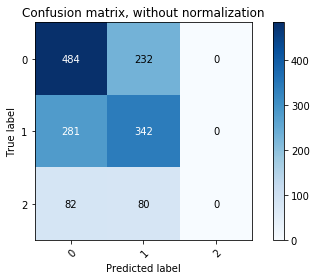

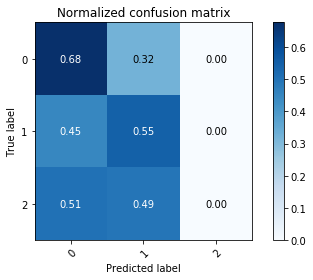

In [27]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    print(classes)
    return ax


np.set_printoptions(precision=2)

y_test = []
y_pred = []

for ind in range(len(true)):
  y_test.append(int(true[ind]))
  y_pred.append(int(pred[ind]))
# y_test = true
# y_pred = pred
class_names = np.array([0,1,2])
print(y_test[:5])

print(y_pred[:5])

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [28]:
test_eval_examples = processor.get_test_examples(TASK_DATA_DIR)
model_eval(estimator_from_tfhub, test_eval_examples)

INFO:tensorflow:Writing example 0 of 1524


INFO:tensorflow:Writing example 0 of 1524


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: test-0


INFO:tensorflow:guid: test-0


INFO:tensorflow:tokens: [CLS] " a florida judge ruled that the government can ban vegetable gardens because they ' re " " ugly . " " " 2016 - 09 - 16 " [ 112 ##12 ##3 , 121 ##35 ##0 , 126 ##11 ##8 , 126 ##36 ##1 ] " [SEP]


INFO:tensorflow:tokens: [CLS] " a florida judge ruled that the government can ban vegetable gardens because they ' re " " ugly . " " " 2016 - 09 - 16 " [ 112 ##12 ##3 , 121 ##35 ##0 , 126 ##11 ##8 , 126 ##36 ##1 ] " [SEP]


INFO:tensorflow:input_ids: 101 1000 1037 3516 3648 5451 2008 1996 2231 2064 7221 15415 5822 2138 2027 1005 2128 1000 1000 9200 1012 1000 1000 1000 2355 1011 5641 1011 2385 1000 1031 11176 12521 2509 1010 12606 19481 2692 1010 14010 14526 2620 1010 14010 21619 2487 1033 1000 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 1000 1037 3516 3648 5451 2008 1996 2231 2064 7221 15415 5822 2138 2027 1005 2128 1000 1000 9200 1012 1000 1000 1000 2355 1011 5641 1011 2385 1000 1031 11176 12521 2509 1010 12606 19481 2692 1010 14010 14526 2620 1010 14010 21619 2487 1033 1000 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: test-1


INFO:tensorflow:guid: test-1


INFO:tensorflow:tokens: [CLS] says bernie sanders marched with fide ##l castro and che gu ##eva ##ra in cuba . facebook posts ##20 ##19 - 02 - 28 " [ 55 ##7 ##37 , 231 ##75 , 48 ##8 ##9 ##2 , 224 ##38 , 329 ##9 ##5 , 39 ##9 ##7 ##1 , 46 ##85 ##8 , 50 ##7 ##9 ##7 , 820 ##7 ##2 , 81 ##37 ##5 , 53 ##6 ##86 ] " [SEP]


INFO:tensorflow:tokens: [CLS] says bernie sanders marched with fide ##l castro and che gu ##eva ##ra in cuba . facebook posts ##20 ##19 - 02 - 28 " [ 55 ##7 ##37 , 231 ##75 , 48 ##8 ##9 ##2 , 224 ##38 , 329 ##9 ##5 , 39 ##9 ##7 ##1 , 46 ##85 ##8 , 50 ##7 ##9 ##7 , 820 ##7 ##2 , 81 ##37 ##5 , 53 ##6 ##86 ] " [SEP]


INFO:tensorflow:input_ids: 101 2758 15941 12055 9847 2007 26000 2140 11794 1998 18178 19739 13331 2527 1999 7394 1012 9130 8466 11387 16147 1011 6185 1011 2654 1000 1031 4583 2581 24434 1010 20304 23352 1010 4466 2620 2683 2475 1010 19711 22025 1010 29567 2683 2629 1010 4464 2683 2581 2487 1010 4805 27531 2620 1010 2753 2581 2683 2581 1010 26667 2581 2475 1010 6282 24434 2629 1010 5187 2575 20842 1033 1000 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 2758 15941 12055 9847 2007 26000 2140 11794 1998 18178 19739 13331 2527 1999 7394 1012 9130 8466 11387 16147 1011 6185 1011 2654 1000 1031 4583 2581 24434 1010 20304 23352 1010 4466 2620 2683 2475 1010 19711 22025 1010 29567 2683 2629 1010 4464 2683 2581 2487 1010 4805 27531 2620 1010 2753 2581 2683 2581 1010 26667 2581 2475 1010 6282 24434 2629 1010 5187 2575 20842 1033 1000 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: test-2


INFO:tensorflow:guid: test-2


INFO:tensorflow:tokens: [CLS] " i took over the school district when it had a $ 1 billion structural deficit and left them with $ 1 billion in cash and 70 , 000 more students than they have today . " paul val ##las ##20 ##18 - 12 - 31 " [ 321 ##49 , 94 ##9 , 321 ##41 , 321 ##54 , 41 ##9 ##66 , 147 ##56 ] " [SEP]


INFO:tensorflow:tokens: [CLS] " i took over the school district when it had a $ 1 billion structural deficit and left them with $ 1 billion in cash and 70 , 000 more students than they have today . " paul val ##las ##20 ##18 - 12 - 31 " [ 321 ##49 , 94 ##9 , 321 ##41 , 321 ##54 , 41 ##9 ##66 , 147 ##56 ] " [SEP]


INFO:tensorflow:input_ids: 101 1000 1045 2165 2058 1996 2082 2212 2043 2009 2018 1037 1002 1015 4551 8332 15074 1998 2187 2068 2007 1002 1015 4551 1999 5356 1998 3963 1010 2199 2062 2493 2084 2027 2031 2651 1012 1000 2703 11748 8523 11387 15136 1011 2260 1011 2861 1000 1031 24030 26224 1010 6365 2683 1010 24030 23632 1010 24030 27009 1010 4601 2683 28756 1010 16471 26976 1033 1000 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 1000 1045 2165 2058 1996 2082 2212 2043 2009 2018 1037 1002 1015 4551 8332 15074 1998 2187 2068 2007 1002 1015 4551 1999 5356 1998 3963 1010 2199 2062 2493 2084 2027 2031 2651 1012 1000 2703 11748 8523 11387 15136 1011 2260 1011 2861 1000 1031 24030 26224 1010 6365 2683 1010 24030 23632 1010 24030 27009 1010 4601 2683 28756 1010 16471 26976 1033 1000 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: test-3


INFO:tensorflow:guid: test-3


INFO:tensorflow:tokens: [CLS] " john corn ##yn has voted to increase the debt , raise taxes , bail out wall street banks and fund obama ##care . " senate conservatives fund ##20 ##13 - 12 - 09 " [ 88 ##58 ##0 , 88 ##45 ##5 , 113 ##38 , 79 ##6 ##9 ##2 ] " [SEP]


INFO:tensorflow:tokens: [CLS] " john corn ##yn has voted to increase the debt , raise taxes , bail out wall street banks and fund obama ##care . " senate conservatives fund ##20 ##13 - 12 - 09 " [ 88 ##58 ##0 , 88 ##45 ##5 , 113 ##38 , 79 ##6 ##9 ##2 ] " [SEP]


INFO:tensorflow:input_ids: 101 1000 2198 9781 6038 2038 5444 2000 3623 1996 7016 1010 5333 7773 1010 15358 2041 2813 2395 5085 1998 4636 8112 16302 1012 1000 4001 11992 4636 11387 17134 1011 2260 1011 5641 1000 1031 6070 27814 2692 1010 6070 19961 2629 1010 12104 22025 1010 6535 2575 2683 2475 1033 1000 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 1000 2198 9781 6038 2038 5444 2000 3623 1996 7016 1010 5333 7773 1010 15358 2041 2813 2395 5085 1998 4636 8112 16302 1012 1000 4001 11992 4636 11387 17134 1011 2260 1011 5641 1000 1031 6070 27814 2692 1010 6070 19961 2629 1010 12104 22025 1010 6535 2575 2683 2475 1033 1000 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: test-4


INFO:tensorflow:guid: test-4


INFO:tensorflow:tokens: [CLS] " in january 2018 , wal ##mart announced a plan to close 250 sam ' s club warehouses , leaving 100 , 000 workers job ##less . " 2018 - 01 - 12 " [ 1100 ##34 , 130 ##7 ##36 , 134 ##40 ##1 , 208 ##19 , 1609 ##56 ] " [SEP]


INFO:tensorflow:tokens: [CLS] " in january 2018 , wal ##mart announced a plan to close 250 sam ' s club warehouses , leaving 100 , 000 workers job ##less . " 2018 - 01 - 12 " [ 1100 ##34 , 130 ##7 ##36 , 134 ##40 ##1 , 208 ##19 , 1609 ##56 ] " [SEP]


INFO:tensorflow:input_ids: 101 1000 1999 2254 2760 1010 24547 22345 2623 1037 2933 2000 2485 5539 3520 1005 1055 2252 23319 1010 2975 2531 1010 2199 3667 3105 3238 1012 1000 2760 1011 5890 1011 2260 1000 1031 22096 22022 1010 7558 2581 21619 1010 15170 12740 2487 1010 18512 16147 1010 28058 26976 1033 1000 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 1000 1999 2254 2760 1010 24547 22345 2623 1037 2933 2000 2485 5539 3520 1005 1055 2252 23319 1010 2975 2531 1010 2199 3667 3105 3238 1012 1000 2760 1011 5890 1011 2260 1000 1031 22096 22022 1010 7558 2581 21619 1010 15170 12740 2487 1010 18512 16147 1010 28058 26976 1033 1000 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


***** Started evaluation at 2019-12-12 03:46:01.421157 *****
  Num examples = 1524
  Batch size = 8
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:*** Features ***


INFO:tensorflow:*** Features ***


INFO:tensorflow:  namez = input_ids, shape = (1, 128)


INFO:tensorflow:  namez = input_ids, shape = (1, 128)


INFO:tensorflow:  namez = input_mask, shape = (1, 128)


INFO:tensorflow:  namez = input_mask, shape = (1, 128)


INFO:tensorflow:  namez = label_ids, shape = (1,)


INFO:tensorflow:  namez = label_ids, shape = (1,)


INFO:tensorflow:  namez = segment_ids, shape = (1, 128)


INFO:tensorflow:  namez = segment_ids, shape = (1, 128)
ERROR:absl:Operation of type Placeholder (module_apply_tokens/input_ids) is not supported on the TPU. Execution will fail if this op is used in the graph. 
ERROR:absl:Operation of type Placeholder (module_apply_tokens/input_mask) is not supported on the TPU. Execution will fail if this op is used in the graph. 
ERROR:absl:Operation of type Placeholder (module_apply_tokens/segment_ids) is not supported on the TPU. Execution will fail if this op is used in the graph. 
ERROR:absl:Operation of type Placeholder (module_apply_tokens/mlm_positions) is not supported on the TPU. Execution will fail if this op is used in the graph. 
ERROR:absl:Operation of type Placeholder (module_apply_tokens/bert/embeddings/word_embeddings) is not supported on the TPU. Execution will fail if this op is used in the graph. 
ERROR:absl:Operation of type Placeholder (module_apply_tokens/bert/embeddings/token_type_embeddings) is not supported on the TPU. Execu

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2019-12-12T03:46:11Z


INFO:tensorflow:Starting evaluation at 2019-12-12T03:46:11Z


INFO:tensorflow:TPU job name worker


INFO:tensorflow:TPU job name worker


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from gs://tb_logs_amy_personal/bert-tfhub/models/LP/ootb/model.ckpt-1141


INFO:tensorflow:Restoring parameters from gs://tb_logs_amy_personal/bert-tfhub/models/LP/ootb/model.ckpt-1141


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Init TPU system


INFO:tensorflow:Init TPU system


INFO:tensorflow:Initialized TPU in 6 seconds


INFO:tensorflow:Initialized TPU in 6 seconds


INFO:tensorflow:Starting infeed thread controller.


INFO:tensorflow:Starting infeed thread controller.


INFO:tensorflow:Starting outfeed thread controller.


INFO:tensorflow:Starting outfeed thread controller.


INFO:tensorflow:Initialized dataset iterators in 0 seconds


INFO:tensorflow:Initialized dataset iterators in 0 seconds


INFO:tensorflow:Enqueue next (190) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (190) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (190) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (190) batch(es) of data from outfeed.


INFO:tensorflow:Outfeed finished for iteration (0, 0)


INFO:tensorflow:Outfeed finished for iteration (0, 0)


INFO:tensorflow:Evaluation [190/190]


INFO:tensorflow:Evaluation [190/190]


INFO:tensorflow:Stop infeed thread controller


INFO:tensorflow:Stop infeed thread controller


INFO:tensorflow:Shutting down InfeedController thread.


INFO:tensorflow:Shutting down InfeedController thread.


INFO:tensorflow:InfeedController received shutdown signal, stopping.


INFO:tensorflow:InfeedController received shutdown signal, stopping.


INFO:tensorflow:Infeed thread finished, shutting down.


INFO:tensorflow:Infeed thread finished, shutting down.


INFO:tensorflow:infeed marked as finished


INFO:tensorflow:infeed marked as finished


INFO:tensorflow:Stop output thread controller


INFO:tensorflow:Stop output thread controller


INFO:tensorflow:Shutting down OutfeedController thread.


INFO:tensorflow:Shutting down OutfeedController thread.


INFO:tensorflow:OutfeedController received shutdown signal, stopping.


INFO:tensorflow:OutfeedController received shutdown signal, stopping.


INFO:tensorflow:Outfeed thread finished, shutting down.


INFO:tensorflow:Outfeed thread finished, shutting down.


INFO:tensorflow:outfeed marked as finished


INFO:tensorflow:outfeed marked as finished


INFO:tensorflow:Shutdown TPU system.


INFO:tensorflow:Shutdown TPU system.


INFO:tensorflow:Finished evaluation at 2019-12-12-03:46:26


INFO:tensorflow:Finished evaluation at 2019-12-12-03:46:26


INFO:tensorflow:Saving dict for global step 1141: eval_accuracy = 0.56842107, eval_loss = 0.7676375, global_step = 1141, loss = 0.7747661


INFO:tensorflow:Saving dict for global step 1141: eval_accuracy = 0.56842107, eval_loss = 0.7676375, global_step = 1141, loss = 0.7747661


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1141: gs://tb_logs_amy_personal/bert-tfhub/models/LP/ootb/model.ckpt-1141


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1141: gs://tb_logs_amy_personal/bert-tfhub/models/LP/ootb/model.ckpt-1141


INFO:tensorflow:evaluation_loop marked as finished


INFO:tensorflow:evaluation_loop marked as finished


***** Finished evaluation at 2019-12-12 03:46:27.646917 *****
***** Eval results *****
  eval_accuracy = 0.56842107
  eval_loss = 0.7676375
  global_step = 1141
  loss = 0.7747661


In [29]:
test_prediction_examples = processor.get_test_examples(TASK_DATA_DIR)
test_true, test_pred = model_predict(estimator_from_tfhub, test_prediction_examples)

INFO:tensorflow:Writing example 0 of 1524


INFO:tensorflow:Writing example 0 of 1524


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: test-0


INFO:tensorflow:guid: test-0


INFO:tensorflow:tokens: [CLS] " a florida judge ruled that the government can ban vegetable gardens because they ' re " " ugly . " " " 2016 - 09 - 16 " [ 112 ##12 ##3 , 121 ##35 ##0 , 126 ##11 ##8 , 126 ##36 ##1 ] " [SEP]


INFO:tensorflow:tokens: [CLS] " a florida judge ruled that the government can ban vegetable gardens because they ' re " " ugly . " " " 2016 - 09 - 16 " [ 112 ##12 ##3 , 121 ##35 ##0 , 126 ##11 ##8 , 126 ##36 ##1 ] " [SEP]


INFO:tensorflow:input_ids: 101 1000 1037 3516 3648 5451 2008 1996 2231 2064 7221 15415 5822 2138 2027 1005 2128 1000 1000 9200 1012 1000 1000 1000 2355 1011 5641 1011 2385 1000 1031 11176 12521 2509 1010 12606 19481 2692 1010 14010 14526 2620 1010 14010 21619 2487 1033 1000 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 1000 1037 3516 3648 5451 2008 1996 2231 2064 7221 15415 5822 2138 2027 1005 2128 1000 1000 9200 1012 1000 1000 1000 2355 1011 5641 1011 2385 1000 1031 11176 12521 2509 1010 12606 19481 2692 1010 14010 14526 2620 1010 14010 21619 2487 1033 1000 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: test-1


INFO:tensorflow:guid: test-1


INFO:tensorflow:tokens: [CLS] says bernie sanders marched with fide ##l castro and che gu ##eva ##ra in cuba . facebook posts ##20 ##19 - 02 - 28 " [ 55 ##7 ##37 , 231 ##75 , 48 ##8 ##9 ##2 , 224 ##38 , 329 ##9 ##5 , 39 ##9 ##7 ##1 , 46 ##85 ##8 , 50 ##7 ##9 ##7 , 820 ##7 ##2 , 81 ##37 ##5 , 53 ##6 ##86 ] " [SEP]


INFO:tensorflow:tokens: [CLS] says bernie sanders marched with fide ##l castro and che gu ##eva ##ra in cuba . facebook posts ##20 ##19 - 02 - 28 " [ 55 ##7 ##37 , 231 ##75 , 48 ##8 ##9 ##2 , 224 ##38 , 329 ##9 ##5 , 39 ##9 ##7 ##1 , 46 ##85 ##8 , 50 ##7 ##9 ##7 , 820 ##7 ##2 , 81 ##37 ##5 , 53 ##6 ##86 ] " [SEP]


INFO:tensorflow:input_ids: 101 2758 15941 12055 9847 2007 26000 2140 11794 1998 18178 19739 13331 2527 1999 7394 1012 9130 8466 11387 16147 1011 6185 1011 2654 1000 1031 4583 2581 24434 1010 20304 23352 1010 4466 2620 2683 2475 1010 19711 22025 1010 29567 2683 2629 1010 4464 2683 2581 2487 1010 4805 27531 2620 1010 2753 2581 2683 2581 1010 26667 2581 2475 1010 6282 24434 2629 1010 5187 2575 20842 1033 1000 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 2758 15941 12055 9847 2007 26000 2140 11794 1998 18178 19739 13331 2527 1999 7394 1012 9130 8466 11387 16147 1011 6185 1011 2654 1000 1031 4583 2581 24434 1010 20304 23352 1010 4466 2620 2683 2475 1010 19711 22025 1010 29567 2683 2629 1010 4464 2683 2581 2487 1010 4805 27531 2620 1010 2753 2581 2683 2581 1010 26667 2581 2475 1010 6282 24434 2629 1010 5187 2575 20842 1033 1000 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: test-2


INFO:tensorflow:guid: test-2


INFO:tensorflow:tokens: [CLS] " i took over the school district when it had a $ 1 billion structural deficit and left them with $ 1 billion in cash and 70 , 000 more students than they have today . " paul val ##las ##20 ##18 - 12 - 31 " [ 321 ##49 , 94 ##9 , 321 ##41 , 321 ##54 , 41 ##9 ##66 , 147 ##56 ] " [SEP]


INFO:tensorflow:tokens: [CLS] " i took over the school district when it had a $ 1 billion structural deficit and left them with $ 1 billion in cash and 70 , 000 more students than they have today . " paul val ##las ##20 ##18 - 12 - 31 " [ 321 ##49 , 94 ##9 , 321 ##41 , 321 ##54 , 41 ##9 ##66 , 147 ##56 ] " [SEP]


INFO:tensorflow:input_ids: 101 1000 1045 2165 2058 1996 2082 2212 2043 2009 2018 1037 1002 1015 4551 8332 15074 1998 2187 2068 2007 1002 1015 4551 1999 5356 1998 3963 1010 2199 2062 2493 2084 2027 2031 2651 1012 1000 2703 11748 8523 11387 15136 1011 2260 1011 2861 1000 1031 24030 26224 1010 6365 2683 1010 24030 23632 1010 24030 27009 1010 4601 2683 28756 1010 16471 26976 1033 1000 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 1000 1045 2165 2058 1996 2082 2212 2043 2009 2018 1037 1002 1015 4551 8332 15074 1998 2187 2068 2007 1002 1015 4551 1999 5356 1998 3963 1010 2199 2062 2493 2084 2027 2031 2651 1012 1000 2703 11748 8523 11387 15136 1011 2260 1011 2861 1000 1031 24030 26224 1010 6365 2683 1010 24030 23632 1010 24030 27009 1010 4601 2683 28756 1010 16471 26976 1033 1000 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: test-3


INFO:tensorflow:guid: test-3


INFO:tensorflow:tokens: [CLS] " john corn ##yn has voted to increase the debt , raise taxes , bail out wall street banks and fund obama ##care . " senate conservatives fund ##20 ##13 - 12 - 09 " [ 88 ##58 ##0 , 88 ##45 ##5 , 113 ##38 , 79 ##6 ##9 ##2 ] " [SEP]


INFO:tensorflow:tokens: [CLS] " john corn ##yn has voted to increase the debt , raise taxes , bail out wall street banks and fund obama ##care . " senate conservatives fund ##20 ##13 - 12 - 09 " [ 88 ##58 ##0 , 88 ##45 ##5 , 113 ##38 , 79 ##6 ##9 ##2 ] " [SEP]


INFO:tensorflow:input_ids: 101 1000 2198 9781 6038 2038 5444 2000 3623 1996 7016 1010 5333 7773 1010 15358 2041 2813 2395 5085 1998 4636 8112 16302 1012 1000 4001 11992 4636 11387 17134 1011 2260 1011 5641 1000 1031 6070 27814 2692 1010 6070 19961 2629 1010 12104 22025 1010 6535 2575 2683 2475 1033 1000 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 1000 2198 9781 6038 2038 5444 2000 3623 1996 7016 1010 5333 7773 1010 15358 2041 2813 2395 5085 1998 4636 8112 16302 1012 1000 4001 11992 4636 11387 17134 1011 2260 1011 5641 1000 1031 6070 27814 2692 1010 6070 19961 2629 1010 12104 22025 1010 6535 2575 2683 2475 1033 1000 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: test-4


INFO:tensorflow:guid: test-4


INFO:tensorflow:tokens: [CLS] " in january 2018 , wal ##mart announced a plan to close 250 sam ' s club warehouses , leaving 100 , 000 workers job ##less . " 2018 - 01 - 12 " [ 1100 ##34 , 130 ##7 ##36 , 134 ##40 ##1 , 208 ##19 , 1609 ##56 ] " [SEP]


INFO:tensorflow:tokens: [CLS] " in january 2018 , wal ##mart announced a plan to close 250 sam ' s club warehouses , leaving 100 , 000 workers job ##less . " 2018 - 01 - 12 " [ 1100 ##34 , 130 ##7 ##36 , 134 ##40 ##1 , 208 ##19 , 1609 ##56 ] " [SEP]


INFO:tensorflow:input_ids: 101 1000 1999 2254 2760 1010 24547 22345 2623 1037 2933 2000 2485 5539 3520 1005 1055 2252 23319 1010 2975 2531 1010 2199 3667 3105 3238 1012 1000 2760 1011 5890 1011 2260 1000 1031 22096 22022 1010 7558 2581 21619 1010 15170 12740 2487 1010 18512 16147 1010 28058 26976 1033 1000 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 1000 1999 2254 2760 1010 24547 22345 2623 1037 2933 2000 2485 5539 3520 1005 1055 2252 23319 1010 2975 2531 1010 2199 3667 3105 3238 1012 1000 2760 1011 5890 1011 2260 1000 1031 22096 22022 1010 7558 2581 21619 1010 15170 12740 2487 1010 18512 16147 1010 28058 26976 1033 1000 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:*** Features ***


INFO:tensorflow:*** Features ***


INFO:tensorflow:  namez = input_ids, shape = (1, 128)


INFO:tensorflow:  namez = input_ids, shape = (1, 128)


INFO:tensorflow:  namez = input_mask, shape = (1, 128)


INFO:tensorflow:  namez = input_mask, shape = (1, 128)


INFO:tensorflow:  namez = label_ids, shape = (1,)


INFO:tensorflow:  namez = label_ids, shape = (1,)


INFO:tensorflow:  namez = segment_ids, shape = (1, 128)


INFO:tensorflow:  namez = segment_ids, shape = (1, 128)
ERROR:absl:Operation of type Placeholder (module_apply_tokens/input_ids) is not supported on the TPU. Execution will fail if this op is used in the graph. 
ERROR:absl:Operation of type Placeholder (module_apply_tokens/input_mask) is not supported on the TPU. Execution will fail if this op is used in the graph. 
ERROR:absl:Operation of type Placeholder (module_apply_tokens/segment_ids) is not supported on the TPU. Execution will fail if this op is used in the graph. 
ERROR:absl:Operation of type Placeholder (module_apply_tokens/mlm_positions) is not supported on the TPU. Execution will fail if this op is used in the graph. 
ERROR:absl:Operation of type Placeholder (module_apply_tokens/bert/embeddings/word_embeddings) is not supported on the TPU. Execution will fail if this op is used in the graph. 
ERROR:absl:Operation of type Placeholder (module_apply_tokens/bert/embeddings/token_type_embeddings) is not supported on the TPU. Execu

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:TPU job name worker


INFO:tensorflow:TPU job name worker


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from gs://tb_logs_amy_personal/bert-tfhub/models/LP/ootb/model.ckpt-1141


INFO:tensorflow:Restoring parameters from gs://tb_logs_amy_personal/bert-tfhub/models/LP/ootb/model.ckpt-1141


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Init TPU system


INFO:tensorflow:Init TPU system


INFO:tensorflow:Initialized TPU in 13 seconds


INFO:tensorflow:Initialized TPU in 13 seconds


INFO:tensorflow:Starting infeed thread controller.


INFO:tensorflow:Starting infeed thread controller.


INFO:tensorflow:Starting outfeed thread controller.


INFO:tensorflow:Starting outfeed thread controller.


INFO:tensorflow:Initialized dataset iterators in 0 seconds


INFO:tensorflow:Initialized dataset iterators in 0 seconds


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Outfeed finished for iteration (0, 0)


INFO:tensorflow:Outfeed finished for iteration (0, 0)


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.


INFO:tensorflow:prediction_loop marked as finished


INFO:tensorflow:prediction_loop marked as finished


[0, 0, 0, 0, 0]
[0, 0, 1, 1, 0]
classes first: [0 1 2]
Confusion matrix, without normalization
[[867 657]
 [  0   0]]
[0 1]
classes first: [0 1 2]
Normalized confusion matrix
[[0.57 0.43]
 [ nan  nan]]
[0 1]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


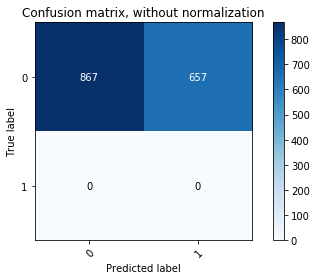

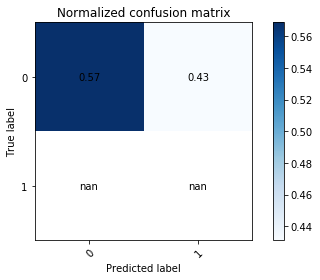

In [30]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    print("classes first:", classes)
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    print(classes)
    return ax


np.set_printoptions(precision=2)

y_test = []
y_pred = []

for ind in range(len(test_true)):
  y_test.append(int(test_true[ind]))
  y_pred.append(int(test_pred[ind]))
# y_test = true
# y_pred = pred
class_names = np.array([0,1,2])
print(y_test[:5])

print(y_pred[:5])

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()